https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=eST5Y9nGqjXW

In [1]:
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=16, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 75380900.86it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_codebook_vectors, dim_codebook_vector, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_codebook_vectors=num_codebook_vectors
        self.dim_codebook_vector = dim_codebook_vector
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_codebook_vectors, dim_codebook_vector)
        self.embedding.weight.data.uniform_(-1/num_codebook_vectors, 1/dim_codebook_vector)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous() #BCHW -> BHWC
        flat_input = inputs.view(-1, self.dim_codebook_vector)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t())) #Squared L2 distances

        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices).view(inputs.shape)

        enc_commitment_loss = F.mse_loss(quantized.detach(), inputs) # loss to make encoder generate inputs similar to quantized version
        codebook_loss = F.mse_loss(quantized, inputs.detach()) # loss to change codebook embeddings
        loss = codebook_loss + self.commitment_cost * enc_commitment_loss

        quantized = inputs + (quantized - inputs).detach() # pass-through gradient from decoder to encoder

        with torch.no_grad(): # for stats
            embed_onehot = F.one_hot(encoding_indices, self.num_codebook_vectors).type(torch.float32)
            avg_probs = torch.mean(embed_onehot, dim=0)
            perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity

In [11]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self.num_residual_layers)])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self.residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = F.relu(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        return self.residual_stack(x)

In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self.residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self.conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self.conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.residual_stack(x)
        x = self.conv_trans_1(x)
        x = F.relu(x)
        return self.conv_trans_2(x)

In [7]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [14]:
class VQ_VAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost):
        super(VQ_VAE, self).__init__()

        self.encoder = Encoder(3, num_hiddens,num_residual_layers,num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        self.quantize = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized, perplexity= self.quantize(z)
        x_recon = self.decoder(quantized)

        return loss, x_recon, perplexity

In [18]:
device = "cuda"
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)


In [19]:
model.train()
import numpy as np
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []

for i in range(num_training_updates):
    (data, _) = next(iter(train_dataloader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    train_vq_loss.append(vq_loss.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('vq_loss: %.3f' % np.mean(train_vq_loss[-100:]))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))


100 iterations
vq_loss: 2.227
recon_error: 0.041
perplexity: 2.969
200 iterations
vq_loss: 0.118
recon_error: 0.021
perplexity: 6.419
300 iterations
vq_loss: 0.029
recon_error: 0.016
perplexity: 10.632
400 iterations
vq_loss: 0.012
recon_error: 0.013
perplexity: 15.854
500 iterations
vq_loss: 0.008
recon_error: 0.012
perplexity: 19.792
600 iterations
vq_loss: 0.005
recon_error: 0.011
perplexity: 22.779
700 iterations
vq_loss: 0.004
recon_error: 0.010
perplexity: 26.396
800 iterations
vq_loss: 0.004
recon_error: 0.010
perplexity: 29.535
900 iterations
vq_loss: 0.003
recon_error: 0.009
perplexity: 32.256
1000 iterations
vq_loss: 0.004
recon_error: 0.008
perplexity: 37.449
1100 iterations
vq_loss: 0.004
recon_error: 0.008
perplexity: 41.463
1200 iterations
vq_loss: 0.005
recon_error: 0.008
perplexity: 45.321
1300 iterations
vq_loss: 0.005
recon_error: 0.007
perplexity: 48.877
1400 iterations
vq_loss: 0.006
recon_error: 0.007
perplexity: 51.211
1500 iterations
vq_loss: 0.006
recon_error: 0

Text(0.5, 0, 'iteration')

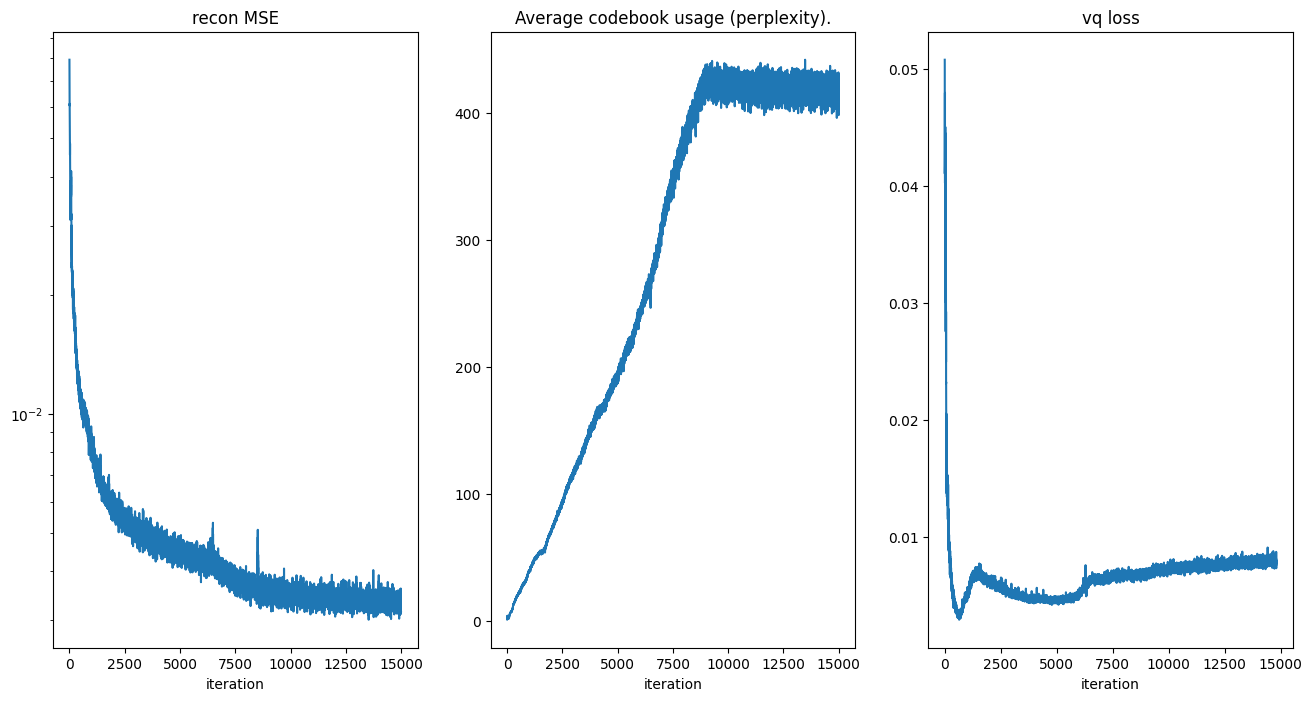

In [27]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,3,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('recon MSE')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,3)
ax.plot(train_vq_loss[200:])
ax.set_title('vq loss')
ax.set_xlabel('iteration')

In [30]:
model=model.eval()

(valid_originals, _) = next(iter(val_dataloader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize, _ = model.quantize(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)

In [31]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

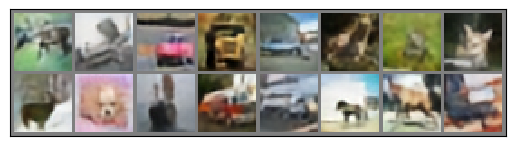

In [32]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

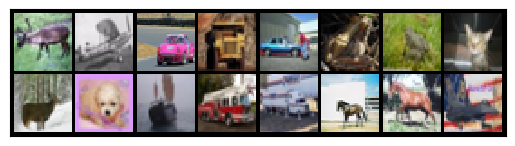

In [33]:
show(make_grid(valid_originals.cpu()+0.5))